In [1]:
import torch

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
from matplotlib.ticker import FixedFormatter
import matplotlib.lines as mlines
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
torch.manual_seed(0)

# Define the red Pareto front.
nadir = 0.0 * torch.ones(1, 2, **tkwargs)

pf1 = torch.tensor(
    [
        [0.3, 0.9],
        [0.5, 0.7],
        [0.6, 0.6],
        [0.7, 0.4],
        [0.95, 0.2],
    ],
    **tkwargs
)

weak_pf1 = torch.row_stack(
    [
        torch.tensor([nadir[0, 0], pf1[0, 1]], **tkwargs),
        pf1,
        torch.tensor([pf1[-1, 0], nadir[0, 1]], **tkwargs),
    ]
)

# Define the blue Pareto front.
pf2 = torch.tensor(
    [
        [0.45, 0.8],
        [0.75, 0.5],
        [0.85, 0.3],
    ],
    **tkwargs
)

weak_pf2 = torch.row_stack(
    [
        torch.tensor([nadir[0, 0], pf2[0, 1]], **tkwargs),
        pf2,
        torch.tensor([pf2[-1, 0], nadir[0, 1]], **tkwargs),
    ]
)

# Define the additional Pareto fronts.
pf3 = torch.zeros(len(pf1) * len(pf2), 2, **tkwargs)
for i, f1 in enumerate(pf1):
    for j, f2 in enumerate(pf2):
        idx = len(pf2) * i + j
        pf3[idx, :] = pf1[i, :] + pf2[j, :]

num_weights = 1001
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)
lengths_1 = s_fn(pf1).max(dim=0).values
lengths_2 = s_fn(pf2).max(dim=0).values
lengths_3 = s_fn(pf3).max(dim=0).values

epsilon = 2.0
weak_pf_add = torch.zeros(num_weights, 2, **tkwargs)
weak_pf3 = torch.zeros(num_weights, 2, **tkwargs)

weak_pf_mult = torch.zeros(num_weights, 2, **tkwargs)
for i, w in enumerate(weights):
    weak_pf_add[i, :] = nadir + (lengths_1[i] + lengths_2[i]) * w
    weak_pf_mult[i, :] = nadir + epsilon * lengths_1[i] * w
    weak_pf3[i, :] = nadir + lengths_3[i] * w


# Interpolate the Pareto fronts.
epsilons = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
num_contours = len(epsilons)
colors = pl.cm.viridis(torch.linspace(0, 1, num_contours))
interpolate_pf = torch.zeros(num_contours, num_weights, 2, **tkwargs)
for i, w in enumerate(weights):
    for j, e in enumerate(epsilons):
        interpolate_pf[j, i, :] = (
            nadir + (e * lengths_1[i] + (1 - e) * lengths_2[i]) * w
        )

# Get the interpolation colours.
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "custom_cmap", cmaplist, cmap.N
)
# Define the bins and normalize.
bounds = torch.linspace(1 / num_contours, num_contours + 1, num_contours + 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

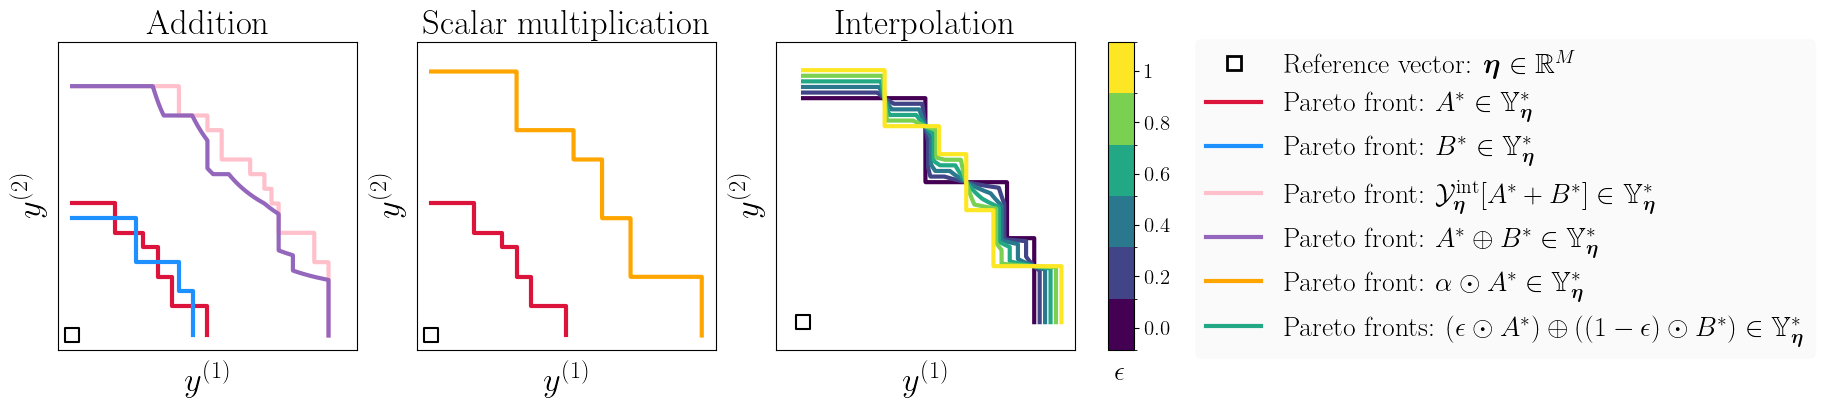

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(13.125, 4))

for i in range(3):
    ax = plt.subplot(1, 3, i + 1)

    ax.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
########################################################################################
# Addition.
ax = plt.subplot(1, 3, 1)
ax.step(
    weak_pf1[:, 0],
    weak_pf1[:, 1],
    color="crimson",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=4,
)
ax.step(
    weak_pf2[:, 0],
    weak_pf2[:, 1],
    color="dodgerblue",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=4,
)
ax.plot(
    weak_pf_add[:, 0],
    weak_pf_add[:, 1],
    color="tab:purple",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=5,
)
ax.plot(
    weak_pf3[:, 0],
    weak_pf3[:, 1],
    color="pink",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=4,
)

ax.set_title("Addition", fontsize=25)
ax.set_xlim([-0.1, 2])
ax.set_ylim([-0.1, 2])
########################################################################################
# Scalar multiplication.
ax = plt.subplot(1, 3, 2)
ax.step(
    weak_pf1[:, 0],
    weak_pf1[:, 1],
    color="crimson",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=4,
)
ax.plot(
    weak_pf_mult[:, 0],
    weak_pf_mult[:, 1],
    color="orange",
    linestyle="-",
    alpha=1,
    linewidth=3,
    zorder=4,
)
ax.set_title("Scalar multiplication", fontsize=25)
ax.set_xlim([-0.1, 2])
ax.set_ylim([-0.1, 2])
########################################################################################
# Interpolation.
ax = plt.subplot(1, 3, 3)
for i, e in enumerate(epsilons):
    ax.plot(
        interpolate_pf[i, :, 0],
        interpolate_pf[i, :, 1],
        color=colors[i],
        linestyle="-",
        alpha=1,
        linewidth=3,
        zorder=4,
    )

ax.set_xlim([-0.1, 1])
ax.set_ylim([-0.1, 1])
ax.set_title("Interpolation", fontsize=25)
ax_bar = fig.add_axes([0.925, 0.11, 0.02, 0.77])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    norm=norm,
    spacing="proportional",
    ticks=bounds + 0.5,
    boundaries=bounds,
    format=FixedFormatter(["0.0", "0.2", "0.4", "0.6", "0.8", "1"]),
    orientation="vertical",
)
ax_bar.set_xlabel(r"$\epsilon$", fontsize=20)
cbar.ax.tick_params(labelsize=15)
########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $A^* \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

blue_line = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $B^* \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

orange_line = mlines.Line2D(
    [],
    [],
    color="orange",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $\alpha \odot A^* \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

pink_line = mlines.Line2D(
    [],
    [],
    color="pink",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $\mathcal{Y}^{\text{int}}_{\boldsymbol{\eta}}[A^* + B^*] \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

purple_line = mlines.Line2D(
    [],
    [],
    color="tab:purple",
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto front: $A^* \oplus B^* \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

green_line = mlines.Line2D(
    [],
    [],
    color=colors[3],
    linestyle="-",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Pareto fronts: $(\epsilon \odot A^*) \oplus ((1-\epsilon) \odot B^*) \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

axes[2].legend(
    handles=[
        white_square,
        red_line,
        blue_line,
        pink_line,
        purple_line,
        orange_line,
        green_line,
    ],
    ncol=1,
    fontsize=20,
    loc=(1.4, -0.025),
    facecolor="k",
    framealpha=0.02,
)

plt.show()